In [1]:
# Challenge: https://www.kaggle.com/c/yelp-restaurant-photo-classification
import os
import numpy as np
import pandas as pd
import IPython
from IPython.display import SVG
import matplotlib.pyplot as plt
from scipy import misc
import pydot

# Keras (https://github.com/fchollet/keras/)
from keras.models import Sequential, Graph
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Convolution1D, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.utils.visualize_util import plot, to_graph
from keras.utils import np_utils, generic_utils
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras import callbacks


%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 20.0) # set default size of plots

Using Theano backend.


## Yelp data provider class

In [2]:
# default image preprocess
def dflt_img_preprocess_fn(img, resize_dim=(480, 480, 3)):
    return misc.imresize(img, resize_dim, interp="nearest")
                
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

# prepare image for vggnet
def prepare_image_for_vggnet(img, resize_dim=(224, 224, 3), sub_vgg_mean=False, depth_first=True, dtype=np.float32):

    if resize_dim == -1:
        img = img.astype(dtype)
    else:
        img = misc.imresize(img, resize_dim, interp="nearest").astype(dtype)

    if sub_vgg_mean:
        img[:,:,0] -= dtype(103.939)
        img[:,:,1] -= dtype(116.779)
        img[:,:,2] -= dtype(123.68)

    if depth_first:
        img = img.transpose((2,0,1))

    return img

"""
train_photo_biz_tbl: training dataframe, photo - biz id 
train_biz_attrib_tbl: training dataframe, biz id - attributes
test_photo_biz_tbl: test dataframe, photo - biz id
"""
class YelpDataCrawler(object):
    
    restaurant_attributes = ["good_for_lunch", "good_for_dinner", "takes_reservations", 
                             "outdoor_seating", "restaurant_is_expensive", "has_alcohol", 
                             "has_table_service", "ambience_is_classy", "good_for_kids"]
   
    def __init__(self, save_processed_data_at="../pdata"):
        
        self.save_processed = save_processed_data_at != None
        self.processed_data_dir = save_processed_data_at
        
    def load_train_data(self, data_dir="../input", 
                                        images_dir="train_photos",
                                        photos_biz_tbl="train_photo_to_biz_ids.csv", 
                                        biz_attrib_tbl="train.csv"):
        
        self.data_dir = data_dir
        self.train_images_dir = os.path.join(data_dir, images_dir)
        train_pdata_dir = os.path.join(self.processed_data_dir,'train') if self.save_processed else ""
        
        if self.save_processed and os.path.isdir(train_pdata_dir):
            
            self.train_photo_biz_tbl = pd.read_csv(os.path.join(train_pdata_dir, photos_biz_tbl))
            self.train_biz_attrib_tbl = pd.read_csv(os.path.join(train_pdata_dir, biz_attrib_tbl))
        else:
            
            self.train_photo_biz_tbl = pd.read_csv(os.path.join(data_dir, photos_biz_tbl))
            self.train_biz_attrib_tbl = pd.read_csv(os.path.join(data_dir, biz_attrib_tbl))
            
            # remove nas and duplicates
            self.train_biz_attrib_tbl = self.train_biz_attrib_tbl.dropna()
            self.train_biz_attrib_tbl = self.train_biz_attrib_tbl.drop_duplicates()
            
            # remove entries with no attributes
            self.train_photo_biz_tbl = self.train_photo_biz_tbl[self.train_photo_biz_tbl['business_id'].apply(
                                                        lambda x: x in self.train_biz_attrib_tbl.business_id.values)]
            
            if self.save_processed:
                
                # create dir to store processed data 
                mkdir_p(os.path.join(train_pdata_dir))

                # save processed tables to disk
                self.train_photo_biz_tbl.to_csv(os.path.join(train_pdata_dir, photos_biz_tbl), index=False)
                self.train_biz_attrib_tbl.to_csv(os.path.join(train_pdata_dir, biz_attrib_tbl), index=False)
                
        self.num_train_images = self.train_photo_biz_tbl.photo_id.size
        self.num_train_biz = self.train_photo_biz_tbl.business_id.unique().size
        self.num_out_classes = len(self.restaurant_attributes)
        
    def load_test_data(self, test_data_dir="../input",
                                        images_dir="test_photos",
                                        photos_biz_tbl="test_photo_to_biz.csv"):
        
        self.test_data_dir = test_data_dir
        self.test_images_dir = os.path.join(test_data_dir, images_dir)
        test_pdata_dir = os.path.join(self.processed_data_dir,'test') if self.save_processed else ""
    
        if self.save_processed and os.path.isdir(test_pdata_dir):
            
            self.test_photo_biz_tbl = pd.read_csv(os.path.join(test_pdata_dir, photos_biz_tbl))
        else:
            
            self.test_photo_biz_tbl = pd.read_csv(os.path.join(test_data_dir, photos_biz_tbl))
            
            if self.save_processed:
                
                # create dir to store processed data 
                mkdir_p(os.path.join(test_pdata_dir))

                # save processed tables to disk
                self.test_photo_biz_tbl.to_csv(os.path.join(test_pdata_dir, photos_biz_tbl), index=False)
                
        self.num_test_images = self.test_photo_biz_tbl.photo_id.size
        self.num_test_biz = self.test_photo_biz_tbl.business_id.unique().size
    
    # get business attributes by biz id
    def get_train_biz_attribs_by_biz_id(self, biz_id):
        return self.train_biz_attrib_tbl[
                        self.train_biz_attrib_tbl.business_id == biz_id]['labels'].as_matrix()[0].split()
    
    # get one-hot encoded business attributes by biz id
    def get_train_biz_attribs_one_hot_by_biz_id(self, biz_id):
        return np.array([(0,1)[str(i) in self.get_train_biz_attribs_by_biz_id(biz_id)] \
                                                            for i in range(len(self.restaurant_attributes))])
    
    # read image from disk
    def read_image(self, img_file_path):
        return misc.imread(img_file_path)
    
    # get training image by id
    def get_train_image_by_img_id(self, img_id):
        return self.read_image(os.path.join(self.train_images_dir, str(img_id)+".jpg"))
    
    # get training image by index (image to biz table)
    def get_train_image_by_img_idx(self, img_idx):
        return self.get_train_image_by_img_id(self.train_photo_biz_tbl.iloc[img_idx]["photo_id"])
    
    # get training image ids associated with a biz id
    def get_train_image_ids_by_biz_id(self, biz_id):
        return self.train_photo_biz_tbl[self.train_photo_biz_tbl.business_id == biz_id]["photo_id"].as_matrix()
    
    # get training images by biz id
    def get_train_images_by_biz_id(self, biz_id, img_preprocess_fn=dflt_img_preprocess_fn, 
                                                                    req_max_imgs=10, shuffle=False):
        
        biz_img_ids = self.get_train_image_ids_by_biz_id(biz_id)[:req_max_imgs]
        if shuffle: 
            np.random.shuffle(biz_img_ids)
        return np.array([img_preprocess_fn(self.get_train_image_by_img_id(img_id)) for img_id in biz_img_ids])

    # read test image by id
    def get_test_image_by_img_id(self, img_id):
        return self.read_image(os.path.join(self.test_images_dir, str(img_id)+".jpg"))    
    
    # get test image by index (image to biz table)
    def get_test_image_by_img_idx(self, img_idx):
        return self.get_test_image_by_img_id(self.test_photo_biz_tbl.iloc[img_idx]["photo_id"])

    # get test image ids associated with a biz id
    def get_test_image_ids_by_biz_id(self, biz_id):
        return self.test_photo_biz_tbl[self.test_photo_biz_tbl.business_id == biz_id]["photo_id"].as_matrix()
    
    # get test images by biz id
    def get_test_images_by_biz_id(self, biz_id, img_preprocess_fn=dflt_img_preprocess_fn,
                                                                      req_max_imgs=10, shuffle=False):
        
        biz_img_ids = self.get_test_image_ids_by_biz_id(biz_id)[:req_max_imgs]
        if shuffle: 
            np.random.shuffle(biz_img_ids)
        return np.array([img_preprocess_fn(self.get_test_image_by_img_id(img_id)) for img_id in biz_img_ids])
    
    def sample_train_images(self, sample_size, img_preprocess_fn=dflt_img_preprocess_fn, 
                                                                        replace=False, rand_seed=None):

        shuffle = True
        
        if self.train_photo_biz_tbl.index.size < sample_size:
            raise Exception("TrainSampleFinished")
        
        sample_photobiz_tbl = self.train_photo_biz_tbl.sample(n=sample_size, replace=replace, random_state=rand_seed) 
        
        X_inputs = np.array([img_preprocess_fn(self.get_train_image_by_img_id(img_id)) \
                                                for img_id in sample_photobiz_tbl["photo_id"] ])
        y_labels = np.array([self.get_train_biz_attribs_one_hot_by_biz_id(biz_id) \
                                                for biz_id in sample_photobiz_tbl["business_id"]])
        
        if replace == False:
            self.train_photo_biz_tbl = self.train_photo_biz_tbl.drop(sample_photobiz_tbl.index)            
            
        return X_inputs, y_labels
    
    def iterate_train_images_by_class(self, class_name, req_max_biz=10, req_max_imgs=10, shuffle=False):
        
        bizattrib_tbl = self.train_biz_attrib_tbl
        photobiz_tbl = self.train_photo_biz_tbl
        filtered_tbl = bizattrib_tbl[bizattrib_tbl["labels"].apply(
                                lambda x: str(self.restaurant_attributes.index(class_name)) in str(x).split())]
        
        if shuffle:
            filtered_tbl = filtered_tbl.reindex(np.random.permutation(filtered_tbl.index))
        
        for biz_id in filtered_tbl[:req_max_biz]["business_id"]:
            for img_id in photobiz_tbl[photobiz_tbl.business_id == biz_id][:req_max_imgs]["photo_id"]:
                yield self.get_train_image_by_img_id(img_id)
    
    def iterate_train_biz_images(self, img_preprocess_fn=dflt_img_preprocess_fn, req_max_imgs=10, shuffle=False):
            
        for biz_id in self.train_photo_biz_tbl.business_id.unique():
            biz_imgs = self.get_train_images_by_biz_id(biz_id, img_preprocess_fn, req_max_imgs, shuffle)
            yield biz_id, biz_imgs
            
    def iterate_test_biz_images(self, img_preprocess_fn=dflt_img_preprocess_fn, req_max_imgs=10, shuffle=False):

        for biz_id in self.test_photo_biz_tbl.business_id.unique():
            
            biz_imgs = self.get_test_images_by_biz_id(biz_id, img_preprocess_fn, req_max_imgs, shuffle)
            yield biz_id, biz_imgs

## Reading training data

In [3]:
YelpData = YelpDataCrawler()
YelpData.load_train_data()

## Sampling training data

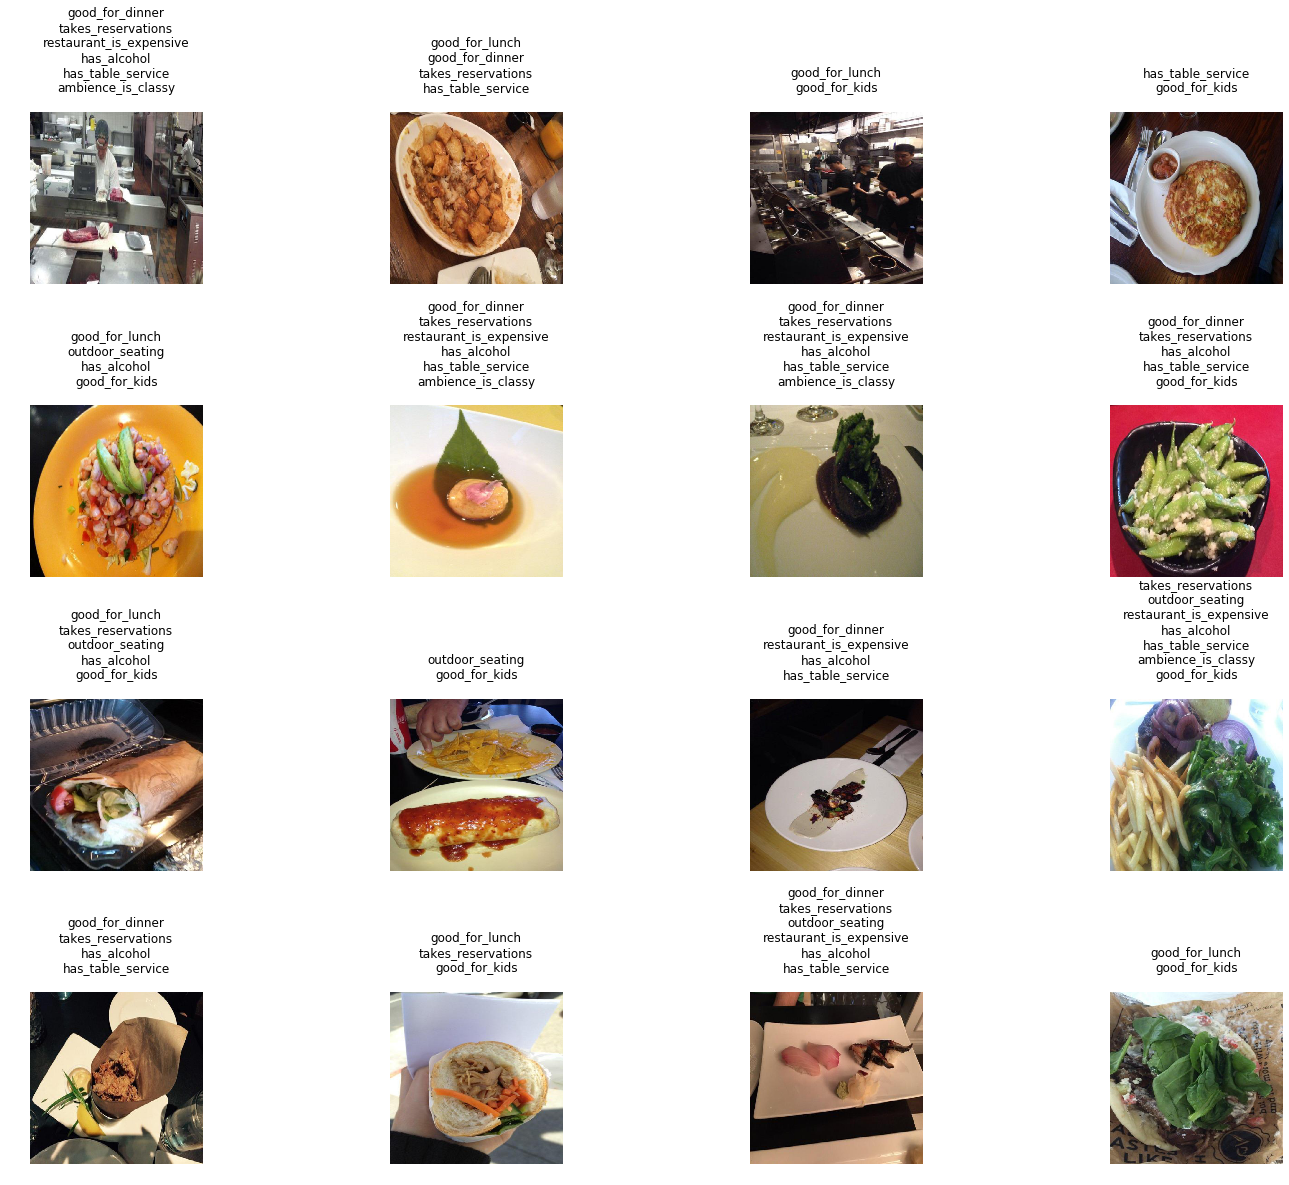

In [4]:
num_samples = 16
xtr, ytr = YelpData.sample_train_images(num_samples, img_preprocess_fn=dflt_img_preprocess_fn, replace=False)
for i in range(num_samples):
    plt.subplot(np.sqrt(num_samples)+1, np.sqrt(num_samples), i+1)
    title_str = "".join([ YelpData.restaurant_attributes[idx] + "\n" for idx,val in enumerate(ytr[i]) if val])
    plt.title(title_str)
    plt.imshow(xtr[i])
    plt.axis('off')
plt.tight_layout(pad=0)

## Sampling images by restaurant class

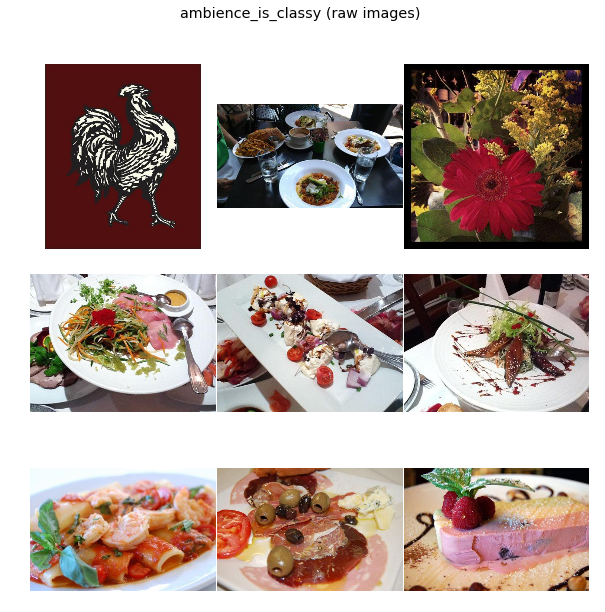

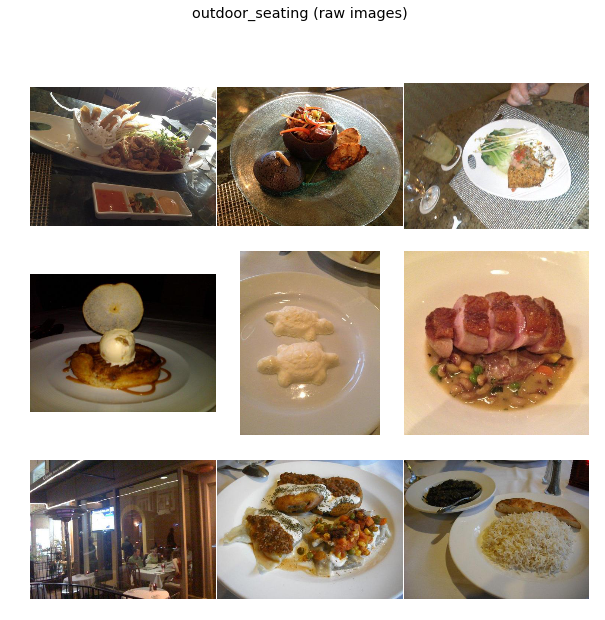

In [5]:
class_names =  ["ambience_is_classy", "outdoor_seating"]
req_max_biz, req_max_imgs_per_biz = 3, 3

for i, class_name in enumerate(class_names):
    fig = plt.figure(i+1, figsize=(10,10))
    st = fig.suptitle(class_name + " (raw images)", fontsize="x-large")    
    fig.subplots_adjust(wspace=0.01, hspace=0.01)
    for image_no, img in enumerate(YelpData.iterate_train_images_by_class(
                                       class_name, req_max_biz, req_max_imgs_per_biz, shuffle=True)):
        fig.add_subplot(req_max_biz, req_max_imgs_per_biz, image_no+1)
        plt.axis("off")
        plt.imshow(img)

## Sampling images by business id

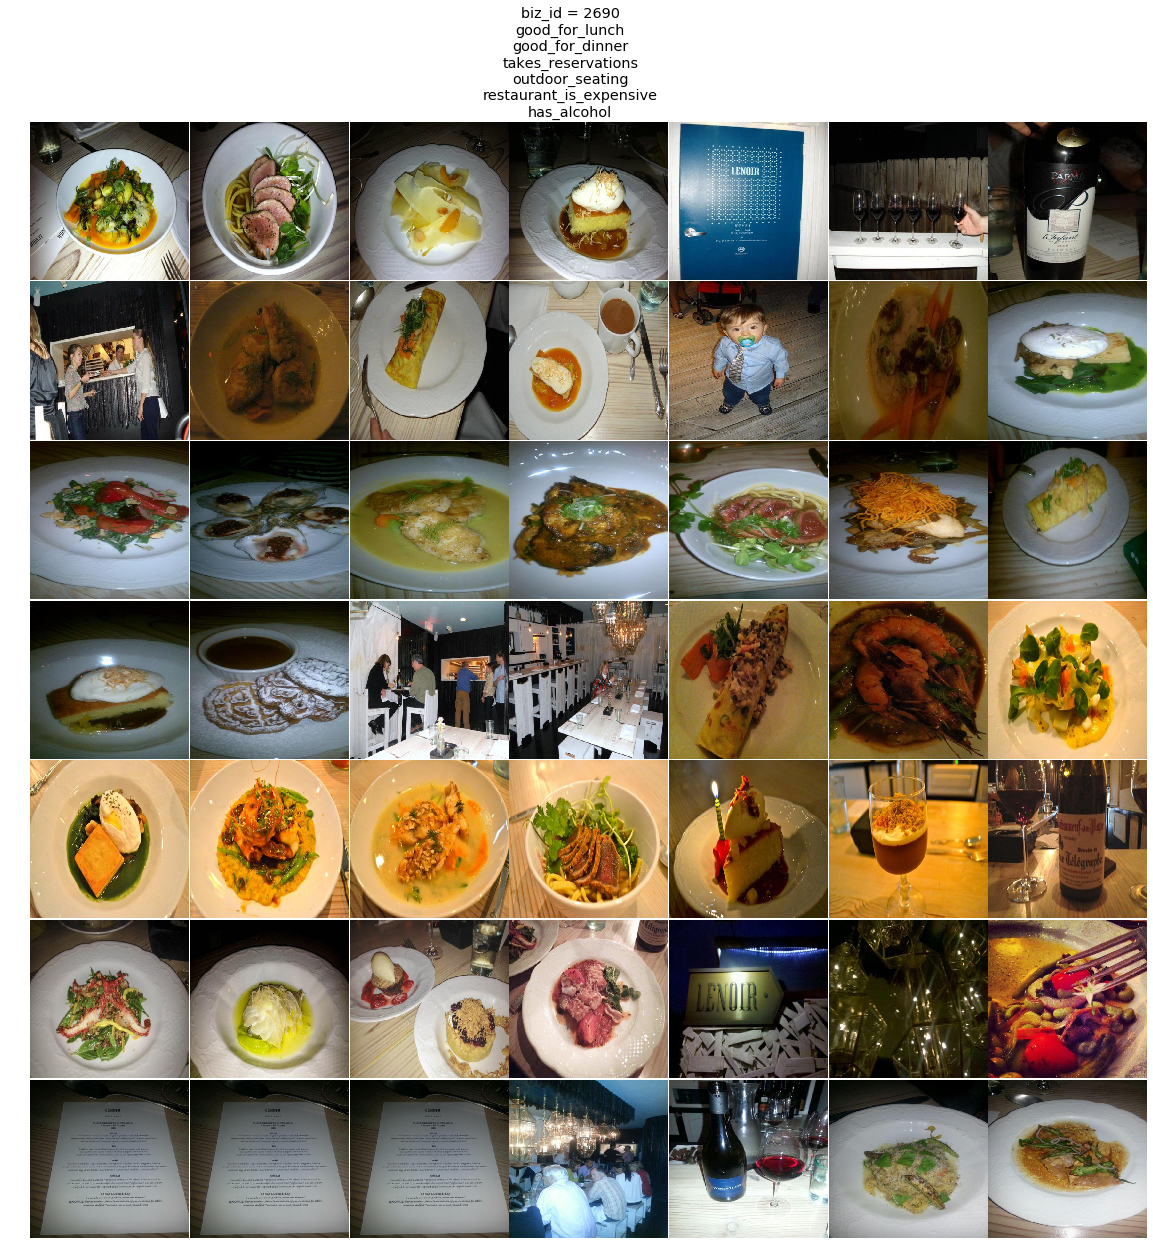

In [19]:
biz_id = YelpData.train_photo_biz_tbl.business_id[np.random.randint(0, YelpData.num_train_biz)]
X_train = YelpData.get_train_images_by_biz_id(biz_id, req_max_imgs=49)
y_train = YelpData.get_train_biz_attribs_by_biz_id(biz_id)
num_imgs = len(X_train)

fig = plt.figure(1, figsize=(20,20))
fig.subplots_adjust(wspace=0.01, hspace=0.01)
title_str = "biz_id = " + str(biz_id) + "\n" \
            + "".join([ YelpData.restaurant_attributes[idx] + "\n" for idx,val in enumerate(y_train) if val])
plt.suptitle(title_str, fontsize="x-large")
for i in range(num_imgs):
    plt.subplot(np.ceil(np.sqrt(num_imgs)), np.ceil(np.sqrt(num_imgs)), i+1)
    plt.imshow(X_train[i])
    plt.axis("off")


## Training image batches

Training batch 1/14659
Finished training...


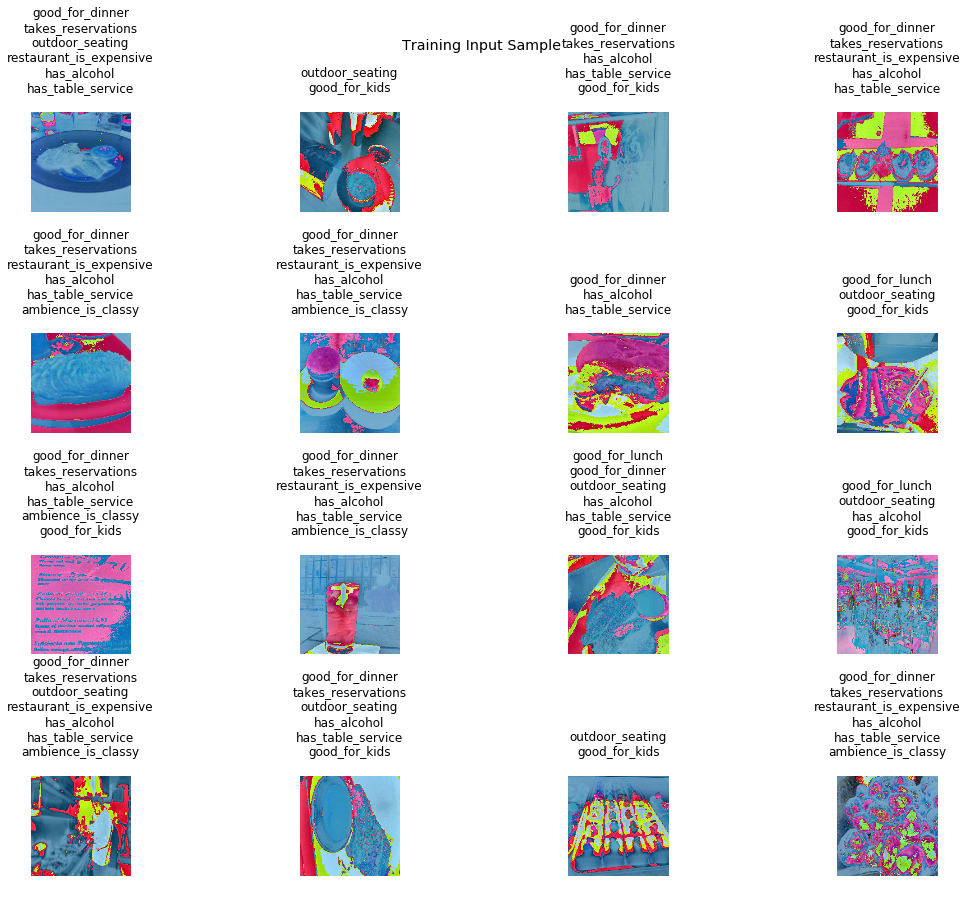

In [20]:
def image_proprocess_vggnet(img):
    img = prepare_image_for_vggnet(img, resize_dim=(224,224,3), 
                                            sub_vgg_mean=True, depth_first=False, dtype=np.float32)
    return img

max_epoch = 1
num_epoch = 0
batch_size = 16
batch_count = 0
while num_epoch < max_epoch:
    try:
        batch_count += 1
        print("Training batch {}/{}".format(batch_count, YelpData.num_train_images/batch_size))
        xtr, ytr = YelpData.sample_train_images(batch_size, img_preprocess_fn=image_proprocess_vggnet, replace=False)
        """
        TRAIN YOUR MODEL HERE
        """
        fig = plt.figure(i+1, figsize=(15,15))
        st = fig.suptitle("Training Input Sample", fontsize="x-large")
        # e.g. code
        for i in range(batch_size):
            plt.subplot(np.sqrt(batch_size)+1, np.sqrt(batch_size), i+1)
            plt.axis('off')
            title_str = "".join([ YelpData.restaurant_attributes[idx] + "\n" \
                                             for idx,val in enumerate(ytr[i]) if val])
            plt.title(title_str)
            plt.imshow(xtr[i])
        plt.tight_layout(pad=0)
        break
        

    except Exception as train_except:
        if "TrainSampleFinished" == train_except.args[0]:
            num_epoch += 1
            print("Train Epoch {}/{}".format(num_epoch, max_epoch))
            # reload training data
            YelpData.load_train_data()
            continue
print("Finished training...")

## VGG16 for tansfer Learning 

In [7]:
# VGG16 (trained on ImageNet)
def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model


# Transfer Learning utility functions
def transfer_learn_conv_layers(dst_model_graph, src_model_seq, transfer_end_at = "conv13"):
    
    conv_idx = 0
    for i in range(len(src_model_seq.layers)):
        
        # vgg16_model.layers[i].name supported in latest keras
        if "Convolution2D" in str(src_model_seq.layers[i]): 
            
            conv_idx += 1
            conv_layer_name = "conv" + str(conv_idx)
            if conv_layer_name in dst_model_graph.namespace:
                
                print('Transferring weights layer {}(src) -> {}(dst) {}'.format(i, conv_idx, conv_layer_name))
                dst_model_graph.nodes[conv_layer_name].W.set_value(src_model_seq.layers[i].get_weights()[0]);
                dst_model_graph.nodes[conv_layer_name].b.set_value(src_model_seq.layers[i].get_weights()[1]);
        
            if conv_layer_name == transfer_end_at:
                break
            
def freeze_layers_from_bottom(model_graph, freeze_end_at = "conv4"):

    # freeze bottom layers
    for node_name in model_graph.nodes.keys():
        model_graph.nodes[node_name].trainable = False
        if node_name == freeze_end_at:
            break

## Restaurant Classification Model

In [ ]:
def yelp_clf_multilabel(
                fc_dims=(1024, 512, 1), input_shape=(3, 224, 224), 
                num_classes=9, l2_reg=0.1, fc_initialization="he_normal", weights_path=None):
    
    fc1_dim, fc2_dim, output_dim = fc_dims
    
    m = Graph()
    
    #64 repr
    m.add_input(name='input', input_shape=input_shape)
    m.add_node(ZeroPadding2D((1,1)), name="pad0", input="input")
    m.add_node(Convolution2D(64, 3, 3, activation='relu'), name="conv1", input="pad0")
    m.add_node(ZeroPadding2D((1,1)), name="pad1", input="conv1")
    m.add_node(Convolution2D(64, 3, 3, activation='relu'), name="conv2", input="pad1")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp2", input="conv2")

    #128 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad2", input="maxp2")
    m.add_node(Convolution2D(128, 3, 3, activation='relu'), name="conv3", input="pad2")
    m.add_node(ZeroPadding2D((1,1)), name="pad3", input="conv3")
    m.add_node(Convolution2D(128, 3, 3, activation='relu'), name="conv4", input="pad3")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp4", input="conv4")

    #256 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad4", input="maxp4")
    m.add_node(Convolution2D(256, 3, 3, activation='relu'), name="conv5", input="pad4")
    m.add_node(ZeroPadding2D((1,1)), name="pad5", input="conv5")
    m.add_node(Convolution2D(256, 3, 3, activation='relu'), name="conv6", input="pad5")
    m.add_node(ZeroPadding2D((1,1)), name="pad6", input="conv6")
    m.add_node(Convolution2D(256, 3, 3, activation='relu'), name="conv7", input="pad6")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp7", input="conv7")

    #512 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad7", input="maxp7")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv8", input="pad7")
    m.add_node(ZeroPadding2D((1,1)), name="pad8", input="conv8")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv9", input="pad8")
    m.add_node(ZeroPadding2D((1,1)), name="pad9", input="conv9")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv10", input="pad9")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp10", input="conv10")
    
    #512 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad10", input="maxp10")
    m.add_node(Convolution2D(512, 3, 3, activation='relu', subsample=(2,2)), name="conv11", input="pad10")
    m.add_node(ZeroPadding2D((1,1)), name="pad11", input="conv11")
    m.add_node(Convolution2D(512, 3, 3, activation='relu', subsample=(2,2)), name="conv12", input="pad11")
    m.add_node(ZeroPadding2D((1,1)), name="pad12", input="conv12")
    m.add_node(Convolution2D(512, 3, 3, activation='relu', subsample=(2,2)), name="conv13", input="pad12")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp13", input="conv13")
    
    m.add_node(Flatten(), name="fork", input="conv13")

    for i in range(num_classes):
        
        layer_name = "h" + str(i) + "fc1"
        m.add_node(Dense(fc1_dim, init=fc_initialization, W_regularizer=l2(l2_reg)), name=layer_name, input="fork")
        prev_layer = layer_name
        layer_name = "h" + str(i) + "fc1relu"
        m.add_node(PReLU(), name=layer_name, input=prev_layer)
        prev_layer = layer_name
        layer_name = "h" + str(i) + "fc1batchnorm"
        m.add_node(BatchNormalization(), name=layer_name, input=prev_layer)
        
        prev_layer = layer_name
        layer_name = "h" + str(i) + "fc2"
        m.add_node(Dense(fc1_dim, init=fc_initialization, W_regularizer=l2(l2_reg)), name=layer_name, input=prev_layer)
        prev_layer = layer_name
        layer_name = "h" + str(i) + "fc2relu"
        m.add_node(PReLU(), name=layer_name, input=prev_layer)
        prev_layer = layer_name
        layer_name = "h" + str(i) + "fc2batchnorm"
        m.add_node(BatchNormalization(), name=layer_name, input=prev_layer)
        
        prev_layer = layer_name
        layer_name = "h" + str(i) + "out"
        m.add_node(Dense(output_dim, activation='sigmoid', 
                             init=fc_initialization, W_regularizer=l2(l2_reg)), name=layer_name, input=prev_layer)
        
        m.add_output(name='class_'+str(i), input=layer_name)

    if weights_path and os.path.isfile(weights_path):
        print "loading pre-trained weights from: ", weights_path
        m.load_weights(weights_path)

    return m

In [24]:
# Tile business images into a single image
num_biz_image_tiles = 16 # must be a perfect square
W, H, C = 224, 224, 3
W_tile_cnt = H_tile_cnt = int(np.sqrt(num_biz_image_tiles))
WT, HT = W_tile_cnt*W, H_tile_cnt*H
fc_dims = (256, 128, 1)

print("Input shape {}x{}".format(WT, HT))

yelp_weights_path = "./weights_9_clf_512_256_1.h5"

try:
  yelp_model
except NameError:
  pass
else:
    print "Freeing up old model"
    del yelp_model

if yelp_weights_path and os.path.isfile(yelp_weights_path):
    
    # start from previous state
    print('Load previous model from disk')
    yelp_model = yelp_restaurant_classifier(
                        fc_dims=fc_dims, input_shape=(C, WT, HT), l2_reg=1.0, weights_path=yelp_weights_path)
    freeze_layers_from_bottom(yelp_model, "conv4")
    
else:
    
    # transfer learn from VGG16
    print('Creating new model...')
    yelp_model = yelp_restaurant_classifier(
                        fc_dims=fc_dims, input_shape=(C, WT, HT), l2_reg=1.0, weights_path=None)
    print('Loading teacher...')
    vgg16_model = VGG_16('../vgg16_weights.h5')
    print('Transfer learning...')
    transfer_learn_conv_layers(yelp_model, vgg16_model, "conv13") # orig: conv13
    freeze_layers_from_bottom(yelp_model, "conv4")
    del vgg16_model
    print('Completed. Ready to learn more.')

In [50]:
# Tile business images to feed into network
num_biz_sampled = 0
train_biz_ids = YelpData.train_biz_attrib_tbl.business_id.unique()

# reset train parameters
def restart_train_minibatch_biz_indexed(start_from_biz_no=0):
    global num_biz_sampled 
    num_biz_sampled = start_from_biz_no
    
def image_proprocess_vggnet(img):
    img = prepare_image_for_vggnet(img, resize_dim=(W,H,C), sub_vgg_mean=True, depth_first=True, dtype=np.float32)
    return img

def get_train_minibatch_biz_indexed(num_biz):
    
    global num_biz_sampled, W_tile_cnt, H_tile_cnt, WT, HT
    
    Xtr_tiled = np.zeros((num_biz, 3, WT, HT))
    ytr_tiled = np.zeros((num_biz, YelpData.num_out_classes))
    
    for batch_indx, biz_id in enumerate(train_biz_ids[num_biz_sampled: num_biz_sampled+num_biz]):
        
        # discard business with insufficient images
        biz_img_count = YelpData.get_train_image_ids_by_biz_id(biz_id).size
        if biz_img_count < num_biz_image_tiles:
            print("Discarding business {} (insufficient no. of images {}, required {})").format(
                                                                biz_id, biz_img_count, num_biz_image_tiles)
            continue
            
        xtr = YelpData.get_train_images_by_biz_id(
                        biz_id, image_proprocess_vggnet, req_max_imgs=num_biz_image_tiles, shuffle=True)
        
        Xtr_tiled[batch_indx, :, :, :] = xtr.transpose(1,0,2,3).reshape(
                        C,W_tile_cnt,H_tile_cnt,W,H).transpose(0,1,3,2,4).reshape(C, WT, HT)
        ytr_tiled[batch_indx,:] = YelpData.get_train_biz_attribs_one_hot_by_biz_id(biz_id)
        
        num_biz_sampled += 1
    return Xtr_tiled, ytr_tiled

## Display model

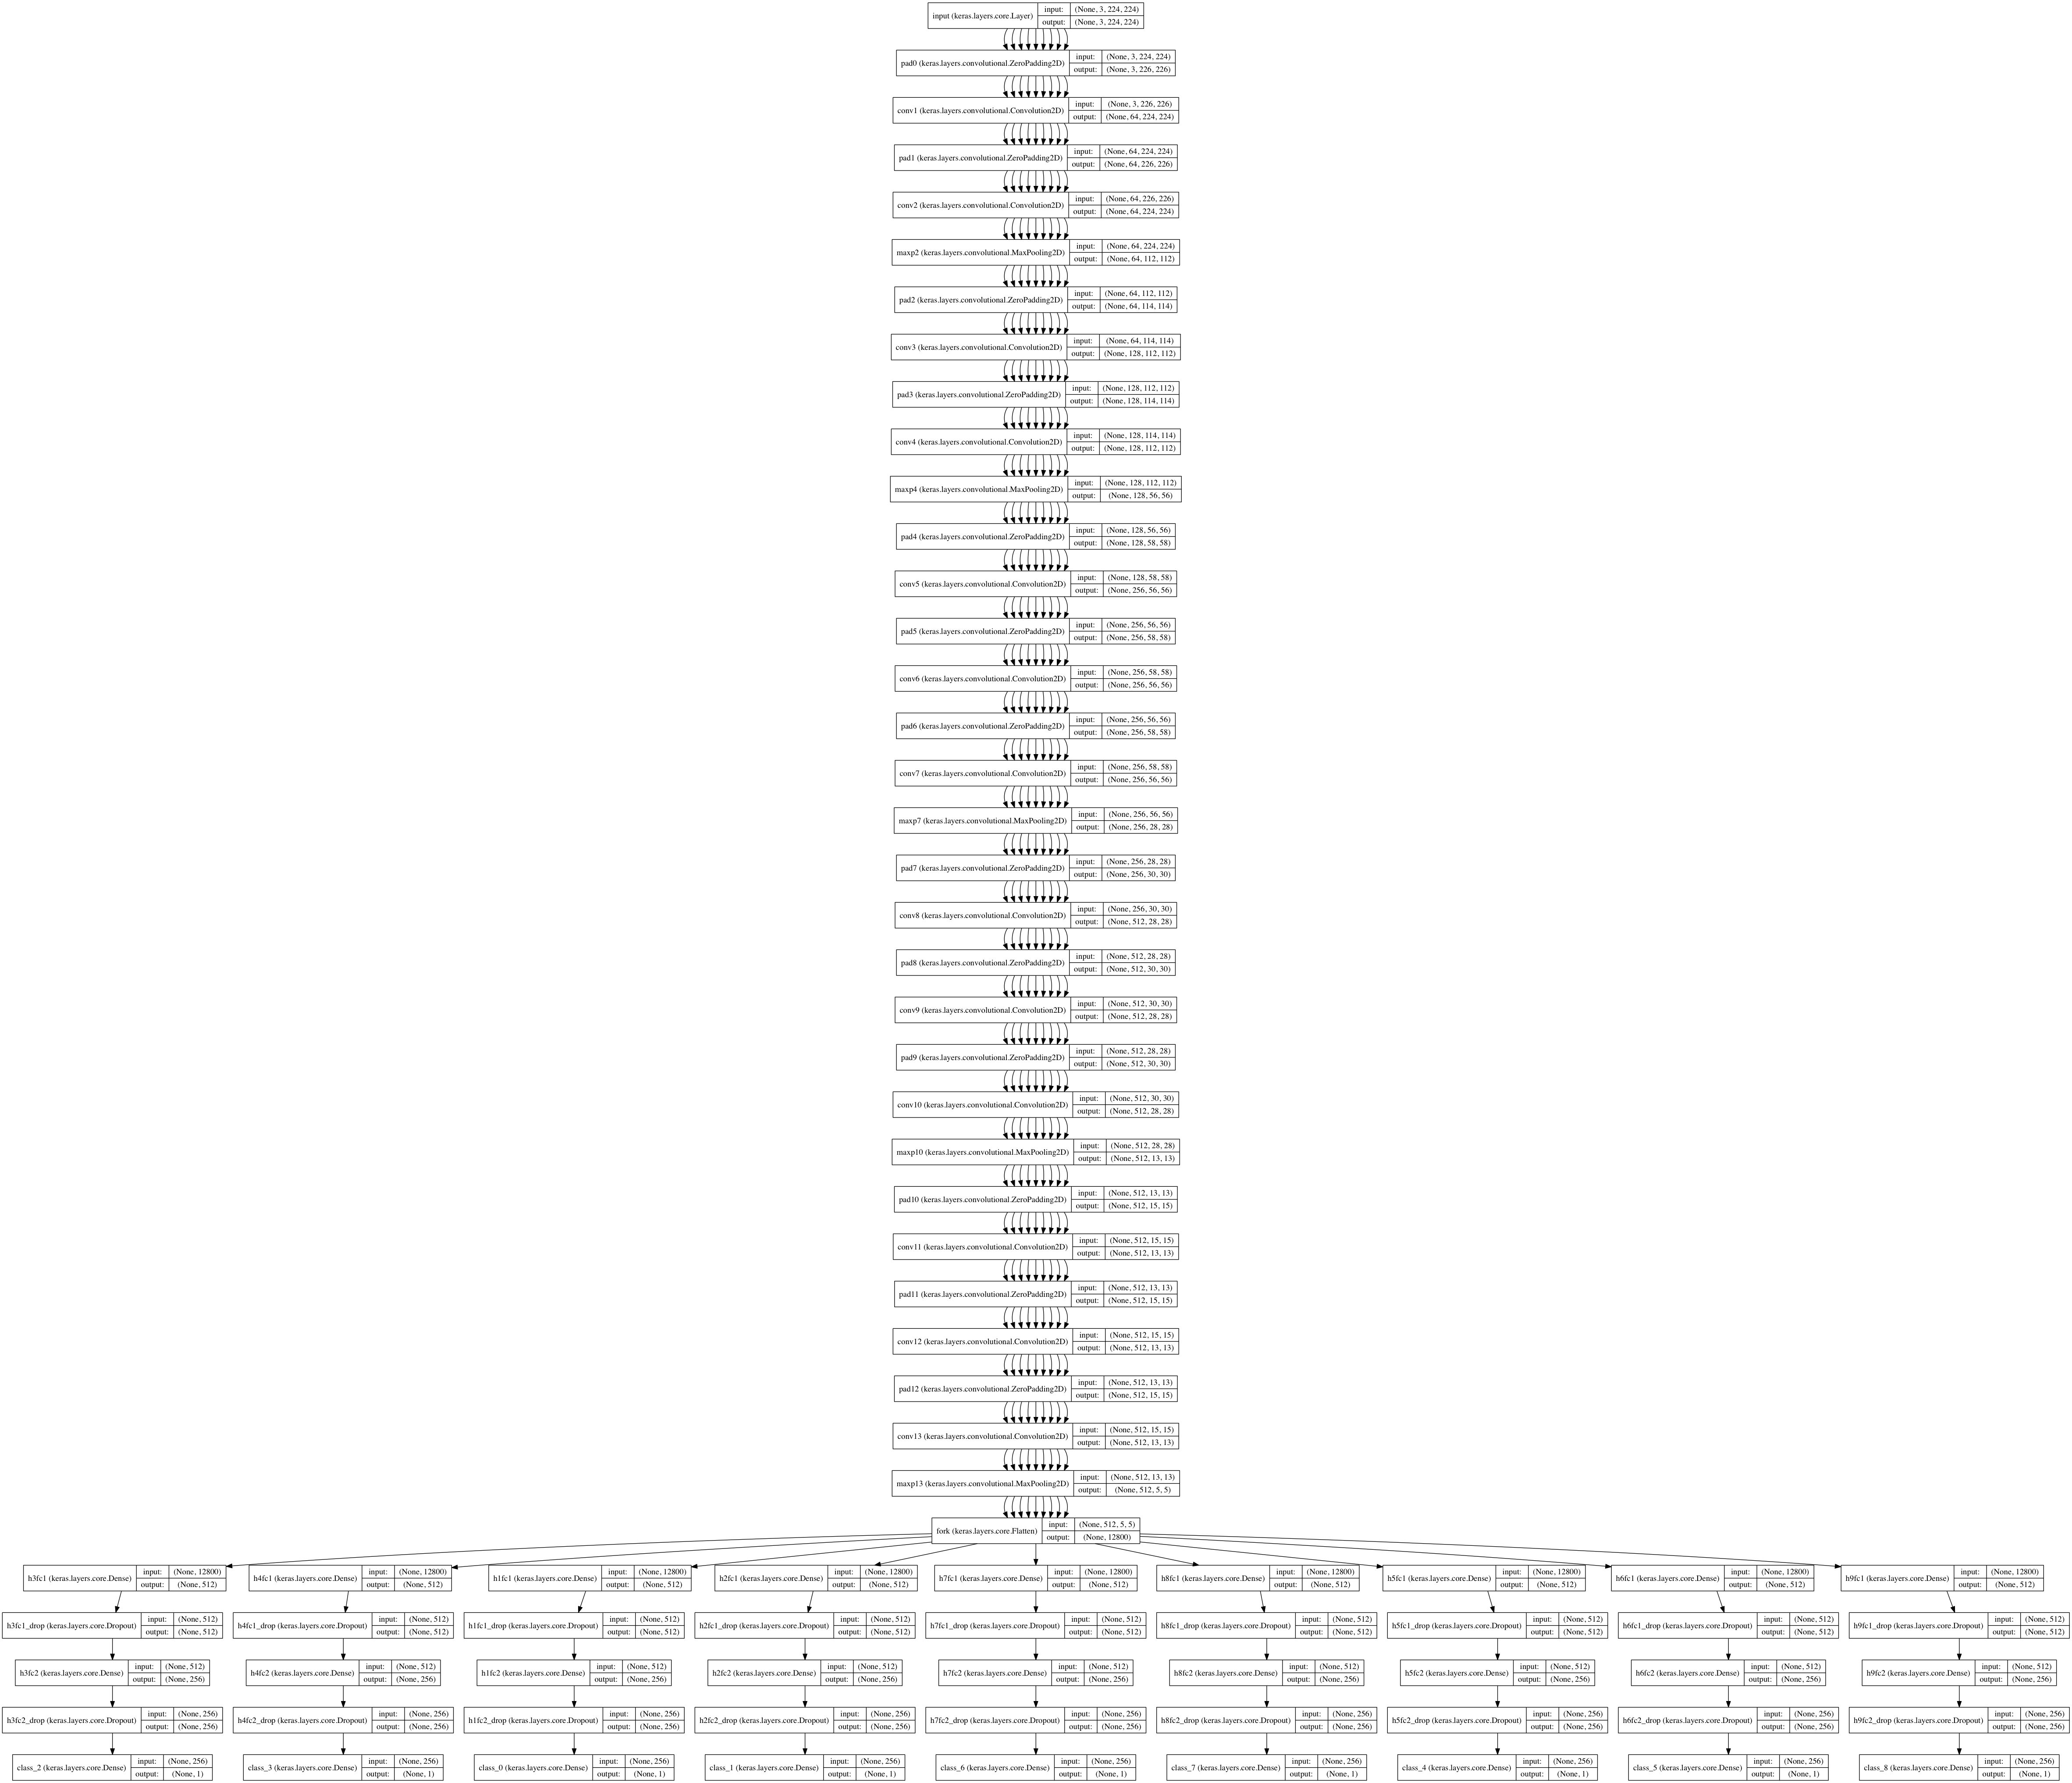

In [12]:
plot(yelp_model, to_file='graph.png', show_shape=True)
IPython.display.Image('./graph.png')
# or 
# SVG(to_graph(yelp_model, show_shape=True).create(prog='dot', format='svg'))

In [54]:
# separate validation set
num_valid = 10
X_valid, y_valid = get_train_minibatch_biz_indexed(num_valid)

Discarding business 1001 (insufficient no. of images 9, required 16)
Discarding business 1010 (insufficient no. of images 11, required 16)


## Optimization

In [13]:
# Callbacks

tr_losses = []
class LossHistory(callbacks.Callback):
    
    def on_batch_end(self, batch, logs={}):
        tr_losses.append(logs.get('loss'))
       
history_cb = LossHistory()
early_stopping_cb = callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')
checkpointer_cb = callbacks.ModelCheckpoint(filepath="/tmp/weights.hdf5", verbose=1, save_best_only=True)

# Compile model
loss_dict = {}
for i in range(len(YelpData.restaurant_attributes)):
    loss_dict['class_'+str(i)] = 'binary_crossentropy'

# loss_dict = {'class_probs':'categorical_crossentropy'}

# sgd = SGD(lr=0.0005, decay=0.0, momentum=0.9, nesterov=True)
adam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
yelp_model.compile(optimizer=adam, loss=loss_dict)

In [ ]:
# yelp_model.load_weights(yelp_weights_path)

In [ ]:
max_epoch = 1
num_epoch = 0
batch_size = 128
batch_count = 0

In [16]:
num_biz_start = num_valid + (batch_count)*batch_size
restart_train_minibatch_biz_indexed(start_from_biz_no=num_biz_start)
while num_epoch < max_epoch:
    
    if num_biz_sampled+batch_size <= train_biz_ids.size:
        
        batch_count += 1
        print("Training batch {}/{}".format(batch_count, YelpData.num_train_biz/batch_size))
        xtr, ytr = get_train_minibatch_biz_indexed(batch_size) 
        keras_training_input = { 'input': xtr } #, 'class_probs': ytr
        for i in range(YelpData.num_out_classes):
            keras_training_input['class_'+str(i)] = ytr[:,i]
            
        yelp_model.fit( keras_training_input, batch_size=2, 
                            verbose=1, nb_epoch=1, validation_split=0.5, 
                            shuffle=True, 
                            callbacks=[history_cb] )
        print('Number of business trained : {}/{}'.format((batch_count)*batch_size, YelpData.num_train_biz))
    else:
        
        num_epoch += 1
        if batch_count:
            
            print("#Epoch {}/{}".format(num_epoch, max_epoch))
            
            if num_epoch == max_epoch:
                print("Finished training...")
            else:
                # restart
                restart_train_minibatch_biz_indexed(start_from_biz_no=num_valid)
                continue
        else:
            print("Failed to train. No data left to sample! (try resetting training parameters)")
            break

In [17]:
# Separate validation set performance
predictions = yelp_model.predict({'input': X_valid}, batch_size=2)
for i in range(len(YelpData.restaurant_attributes)):
    class_prediction = predictions['class_'+str(i)].squeeze()
    class_prediction[class_prediction < 0.5] = 0
    class_prediction[class_prediction >= 0.5] = 1
    class_accuracy = np.mean( np.mean(y_valid[:,i] == class_prediction) )
    print('Class {} Accuracy {}'.format(i, class_accuracy))

In [ ]:
# Validation accuracy
pred_mat = np.array(predictions.values()).squeeze().transpose(1,0)
diff_out = np.sum(y_valid == pred_mat, axis=1)
print("Strict Accuracy = {}".format(np.mean(diff_out/9)))
print("General Accuracy = {}".format(np.mean(diff_out/9.0)))

In [18]:
yelp_model.save_weights("./yelp_restaurant_classifier_weights.h5")

## Test data

In [23]:
YelpData.load_test_data()

In [107]:
test_results_frame = pd.DataFrame(columns=("business_id", "labels"))
count = 0
for (biz_id, X_test) in YelpData.iterate_test_biz_images(image_proprocess_vggnet, 
                                                            req_max_imgs=num_biz_image_tiles, shuffle=True):
    
    biz_img_count = YelpData.get_test_image_ids_by_biz_id(biz_id).size
    if biz_img_count < num_biz_image_tiles:
        print("Discarding business {} (insufficient no. of images {}, required {})").format(
                                                        biz_id, biz_img_count, num_biz_image_tiles)
        # select random classes as a temporary solution
        predictions_mat = np.random.binomial(1, 0.5, (1, YelpData.num_out_classes))
    else:
        Xtest_tiled = X_test.transpose(1,0,2,3).reshape(
                        C,W_tile_cnt,H_tile_cnt,W,H).transpose(0,1,3,2,4).reshape(C, WT, HT)[np.newaxis]
        predictions = yelp_model.predict({'input': Xtest_tiled}, batch_size=1) # {class_name: num_samples x 1}
        predictions_mat = np.expand_dims(np.array(predictions.values()).squeeze(), axis=0) # 1 x num_classes
        predictions_mat[predictions_mat < 0.5] = 0
        predictions_mat[predictions_mat >= 0.5] = 1
        
    biz_pred_str = " ".join([str(i) for i in range(YelpData.num_out_classes) if np.sum(predictions_mat[:, i])])
    test_results_frame.loc[count] = biz_id, biz_pred_str
    count += 1
    if count % 400 == 0:
        print('biz_id processed = {}/{}'.format(count, YelpData.num_test_biz))
        test_results_frame.to_csv("./submission.csv", index=None)

In [104]:
# save results
test_results_frame.to_csv("./submission.csv", index=None)

## Scratchpad

### Statistical mean guess

In [26]:
tbl2 = YelpData.train_biz_attrib_tbl.copy()
for attrib_key, attrib in enumerate(YelpData.restaurant_attributes):
    tbl2[attrib] = tbl2['labels'].str.contains(str(attrib_key))
    
tbs = YelpData.num_test_biz
for i, cls in enumerate(YelpData.restaurant_attributes):
    cls_mu = np.mean(tbl2[cls])
    print("{}: mu = {}".format(cls, cls_mu))
    if i == 0:
        preds = np.random.binomial(1, cls_mu, (tbs,1))
    else:
        preds = np.hstack([preds, np.random.binomial(1, cls_mu, (tbs,1))])

# test_results_frame = pd.DataFrame(columns=("business_id", "labels"))
# for biz_idx, biz_id in enumerate(YelpData.test_photo_biz_tbl.business_id.unique()):
    
#     biz_pred_str = " ".join([str(i) for i in range(YelpData.num_out_classes) if preds[biz_idx,i]])
#     test_results_frame.loc[count] = biz_id, biz_pred_str
#     if biz_idx % 1000 == 0:
#         print('biz_id processed = {}/{}'.format(count, YelpData.num_test_biz))

good_for_lunch: mu = 0.336172344689
good_for_dinner: mu = 0.49749498998
takes_reservations: mu = 0.514028056112
outdoor_seating: mu = 0.50250501002
restaurant_is_expensive: mu = 0.274048096192
has_alcohol: mu = 0.625751503006
has_table_service: mu = 0.681362725451
ambience_is_classy: mu = 0.286573146293
good_for_kids: mu = 0.620240480962


### Random Guess

In [113]:
test_results_frame = pd.DataFrame(columns=("business_id", "labels"))
count = 0
for (biz_id, X_test) in YelpData.iterate_test_biz_images(image_proprocess_vggnet, 
                                                            req_max_imgs=num_biz_image_tiles, shuffle=True):
    predictions_mat = np.random.binomial(1, 0.5, (1, YelpData.num_out_classes))
    biz_pred_str = " ".join([str(i) for i in range(YelpData.num_out_classes) if np.sum(predictions_mat[:, i])])
    test_results_frame.loc[count] = biz_id, biz_pred_str     
    count += 1
    if count % 100 == 0:
        test_results_frame.to_csv("./submission.csv", index=None) 
        print('biz_id processed = {}/{}'.format(count, YelpData.num_test_biz))

In [ ]:
def yelp_restaurant_classifier_fullyconv(
                fc_dims=(1024, 512, 1), input_shape=(3, 224, 224), l2_reg=0.1, weights_path=None):
    
    fc1_dim, fc2_dim, output_dim = fc_dims
    
    m = Graph()
    
    #64 repr
    m.add_input(name='input', input_shape=input_shape)
    m.add_node(ZeroPadding2D((1,1)), name="pad0", input="input")
    m.add_node(Convolution2D(64, 3, 3, activation='relu'), name="conv1", input="pad0")
    m.add_node(ZeroPadding2D((1,1)), name="pad1", input="conv1")
    m.add_node(Convolution2D(64, 3, 3, activation='relu'), name="conv2", input="pad1")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp2", input="conv2")

    #128 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad2", input="maxp2")
    m.add_node(Convolution2D(128, 3, 3, activation='relu'), name="conv3", input="pad2")
    m.add_node(ZeroPadding2D((1,1)), name="pad3", input="conv3")
    m.add_node(Convolution2D(128, 3, 3, activation='relu'), name="conv4", input="pad3")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp4", input="conv4")

    #256 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad4", input="maxp4")
    m.add_node(Convolution2D(256, 3, 3, activation='relu'), name="conv5", input="pad4")
    m.add_node(ZeroPadding2D((1,1)), name="pad5", input="conv5")
    m.add_node(Convolution2D(256, 3, 3, activation='relu'), name="conv6", input="pad5")
    m.add_node(ZeroPadding2D((1,1)), name="pad6", input="conv6")
    m.add_node(Convolution2D(256, 3, 3, activation='relu'), name="conv7", input="pad6")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp7", input="conv7")

    #512 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad7", input="maxp7")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv8", input="pad7")
    m.add_node(ZeroPadding2D((1,1)), name="pad8", input="conv8")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv9", input="pad8")
    m.add_node(ZeroPadding2D((1,1)), name="pad9", input="conv9")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv10", input="pad9")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp10", input="conv10")
    
    #512 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad10", input="maxp10")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv11", input="pad10")
    m.add_node(ZeroPadding2D((1,1)), name="pad11", input="conv11")
    m.add_node(Convolution2D(512, 3, 3, activation='relu', subsample=(2,2)), name="conv12", input="pad11")
    m.add_node(ZeroPadding2D((1,1)), name="pad12", input="conv12")
    m.add_node(Convolution2D(512, 3, 3, activation='relu', subsample=(2,2)), name="conv13", input="pad12")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp13", input="conv13")
    
    m.add_node(Convolution2D(512, 7, 7, activation='relu'), name="conv_1d_0", input="maxp13")
    m.add_node(Convolution2D(1024, 1, 1, activation='relu'), name="conv_1d_1", input="conv_1d_0")
    m.add_node(Convolution2D(512, 1, 1, activation='relu'), name="conv_1d_2", input="conv_1d_1")
    m.add_node(Convolution2D(output_dim, 1, 1, activation='relu'), name="conv_1d_3", input="conv_1d_2")
    
    m.add_node(Flatten(), name="conv_1d_flat", input="conv_1d_3")
    m.add_node(Activation('softmax'), name="conv_1d_flat_prob", input="conv_1d_flat") 
    m.add_output(name='class_probs', input='conv_1d_flat_prob') 

    m.add_output(name='class_probs', input='conv_1d_flat_prob')

    if weights_path and os.path.isfile(weights_path):
        print "loading pre-trained weights from: ", weights_path
        m.load_weights(weights_path)

    return m

In [8]:
def yelp_restaurant_class_classifiers(
                fc_dims=(1024, 512, 1), input_shape=(3, 224, 224), l2_reg=0.1, weights_path=None): 
    
    fc1_dim, fc2_dim, output_dim = fc_dims
    
    m = Graph()
    
    #64 repr
    m.add_input(name='input', input_shape=input_shape)
    m.add_node(ZeroPadding2D((1,1)), name="pad0", input="input")
    m.add_node(Convolution2D(64, 3, 3, activation='relu'), name="conv1", input="pad0")
    m.add_node(ZeroPadding2D((1,1)), name="pad1", input="conv1")
    m.add_node(Convolution2D(64, 3, 3, activation='relu'), name="conv2", input="pad1")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp2", input="conv2")

    #128 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad2", input="maxp2")
    m.add_node(Convolution2D(128, 3, 3, activation='relu'), name="conv3", input="pad2")
    m.add_node(ZeroPadding2D((1,1)), name="pad3", input="conv3")
    m.add_node(Convolution2D(128, 3, 3, activation='relu'), name="conv4", input="pad3")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp4", input="conv4")

    #256 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad4", input="maxp4")
    m.add_node(Convolution2D(256, 3, 3, activation='relu'), name="conv5", input="pad4")
    m.add_node(ZeroPadding2D((1,1)), name="pad5", input="conv5")
    m.add_node(Convolution2D(256, 3, 3, activation='relu'), name="conv6", input="pad5")
    m.add_node(ZeroPadding2D((1,1)), name="pad6", input="conv6")
    m.add_node(Convolution2D(256, 3, 3, activation='relu'), name="conv7", input="pad6")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp7", input="conv7")

    #512 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad7", input="maxp7")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv8", input="pad7")
    m.add_node(ZeroPadding2D((1,1)), name="pad8", input="conv8")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv9", input="pad8")
    m.add_node(ZeroPadding2D((1,1)), name="pad9", input="conv9")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv10", input="pad9")
    m.add_node(MaxPooling2D((4,4), strides=(2,2)), name="maxp10", input="conv10")
    
    #512 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad10", input="maxp10")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv11", input="pad10")
    m.add_node(ZeroPadding2D((1,1)), name="pad11", input="conv11")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv12", input="pad11")
    m.add_node(ZeroPadding2D((1,1)), name="pad12", input="conv12")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv13", input="pad12")
    m.add_node(MaxPooling2D((4,4), strides=(2,2)), name="maxp13", input="conv13")
    
    m.add_node(Flatten(), name="fork", input="maxp13")
    
    m.add_node(Dense(fc1_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h1fc1", input="fork")
    m.add_node(Dropout(0.5), name="h1fc1_drop", input="h1fc1")
    m.add_node(Dense(fc2_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h1fc2", input="h1fc1_drop")
    m.add_node(Dropout(0.5), name="h1fc2_drop", input="h1fc2")
    m.add_node(Dense(output_dim, activation='sigmoid', init='he_normal', W_regularizer = l2(l2_reg)), name="h1out", input="h1fc2_drop")
    
    m.add_node(Dense(fc1_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h2fc1", input="fork")
    m.add_node(Dropout(0.5), name="h2fc1_drop", input="h2fc1")
    m.add_node(Dense(fc2_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h2fc2", input="h2fc1_drop")
    m.add_node(Dropout(0.5), name="h2fc2_drop", input="h2fc2")
    m.add_node(Dense(output_dim, activation='sigmoid', init='he_normal', W_regularizer = l2(l2_reg)), name="h2out", input="h2fc2_drop")
    
    m.add_node(Dense(fc1_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h3fc1", input="fork")
    m.add_node(Dropout(0.5), name="h3fc1_drop", input="h3fc1")
    m.add_node(Dense(fc2_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h3fc2", input="h3fc1_drop")
    m.add_node(Dropout(0.5), name="h3fc2_drop", input="h3fc2")
    m.add_node(Dense(output_dim, activation='sigmoid', init='he_normal', W_regularizer = l2(l2_reg)), name="h3out", input="h3fc2_drop")
    
    m.add_node(Dense(fc1_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h4fc1", input="fork")
    m.add_node(Dropout(0.5), name="h4fc1_drop", input="h4fc1")
    m.add_node(Dense(fc2_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h4fc2", input="h4fc1_drop")
    m.add_node(Dropout(0.5), name="h4fc2_drop", input="h4fc2")
    m.add_node(Dense(output_dim, activation='sigmoid', init='he_normal', W_regularizer = l2(l2_reg)), name="h4out", input="h4fc2_drop")
    
    m.add_node(Dense(fc1_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h5fc1", input="fork")
    m.add_node(Dropout(0.5), name="h5fc1_drop", input="h5fc1")
    m.add_node(Dense(fc2_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h5fc2", input="h5fc1_drop")
    m.add_node(Dropout(0.5), name="h5fc2_drop", input="h5fc2")
    m.add_node(Dense(output_dim, activation='sigmoid', init='he_normal', W_regularizer = l2(l2_reg)), name="h5out", input="h5fc2_drop")
    
    m.add_node(Dense(fc1_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h6fc1", input="fork")
    m.add_node(Dropout(0.5), name="h6fc1_drop", input="h6fc1")
    m.add_node(Dense(fc2_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h6fc2", input="h6fc1_drop")
    m.add_node(Dropout(0.5), name="h6fc2_drop", input="h6fc2")
    m.add_node(Dense(output_dim, activation='sigmoid', init='he_normal', W_regularizer = l2(l2_reg)), name="h6out", input="h6fc2_drop")
    
    m.add_node(Dense(fc1_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h7fc1", input="fork")
    m.add_node(Dropout(0.5), name="h7fc1_drop", input="h7fc1")
    m.add_node(Dense(fc2_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h7fc2", input="h7fc1_drop")
    m.add_node(Dropout(0.5), name="h7fc2_drop", input="h7fc2")
    m.add_node(Dense(output_dim, activation='sigmoid', init='he_normal', W_regularizer = l2(l2_reg)), name="h7out", input="h7fc2_drop")
    
    m.add_node(Dense(fc1_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h8fc1", input="fork")
    m.add_node(Dropout(0.5), name="h8fc1_drop", input="h8fc1")
    m.add_node(Dense(fc2_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h8fc2", input="h8fc1_drop")
    m.add_node(Dropout(0.5), name="h8fc2_drop", input="h8fc2")
    m.add_node(Dense(output_dim, activation='sigmoid', init='he_normal', W_regularizer = l2(l2_reg)), name="h8out", input="h8fc2_drop")
    
    m.add_node(Dense(fc1_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h9fc1", input="fork")
    m.add_node(Dropout(0.5), name="h9fc1_drop", input="h9fc1")
    m.add_node(Dense(fc2_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h9fc2", input="h9fc1_drop")
    m.add_node(Dropout(0.5), name="h9fc2_drop", input="h9fc2")
    m.add_node(Dense(output_dim, activation='sigmoid', init='he_normal', W_regularizer = l2(l2_reg)), name="h9out", input="h9fc2_drop")
    
    m.add_output(name='class_0', input='h1out')
    m.add_output(name='class_1', input='h2out')
    m.add_output(name='class_2', input='h3out')
    m.add_output(name='class_3', input='h4out')
    m.add_output(name='class_4', input='h5out')
    m.add_output(name='class_5', input='h6out')
    m.add_output(name='class_6', input='h7out')
    m.add_output(name='class_7', input='h8out')
    m.add_output(name='class_8', input='h9out')

    if weights_path and os.path.isfile(weights_path):
        print "loading pre-trained weights from: ", weights_path
        m.load_weights(weights_path)

    return m

## GPU Test

In [23]:
# GPU test: http://deeplearning.net/software/theano/tutorial/using_gpu.html

from theano import function, config, shared, tensor, sandbox
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], tensor.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, tensor.Elemwise) and
              ('Gpu' not in type(x.op).__name__)
              for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')


In [22]:
# Check GPU Memory 
import theano.sandbox.cuda.basic_ops as sbcuda
import theano.tensor as T
T.config.floatX = 'float32'
GPUFreeMemoryInBytes = sbcuda.cuda_ndarray.cuda_ndarray.mem_info()[0]
freeGPUMemInGBs = GPUFreeMemoryInBytes/1024./1024/1024
print "Your GPU has %s GBs of free memory" % str(freeGPUMemInGBs)

In [ ]:
# Display vgg16 model
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
vgg16_model.compile(optimizer=sgd, loss='categorical_crossentropy')
SVG(to_graph(vgg16_model, show_shape=True).create(prog='dot', format='svg'))

## Min business images analysis

images per biz min = 2, max = 2973, mean = 117.491482966, std = 205.123132353


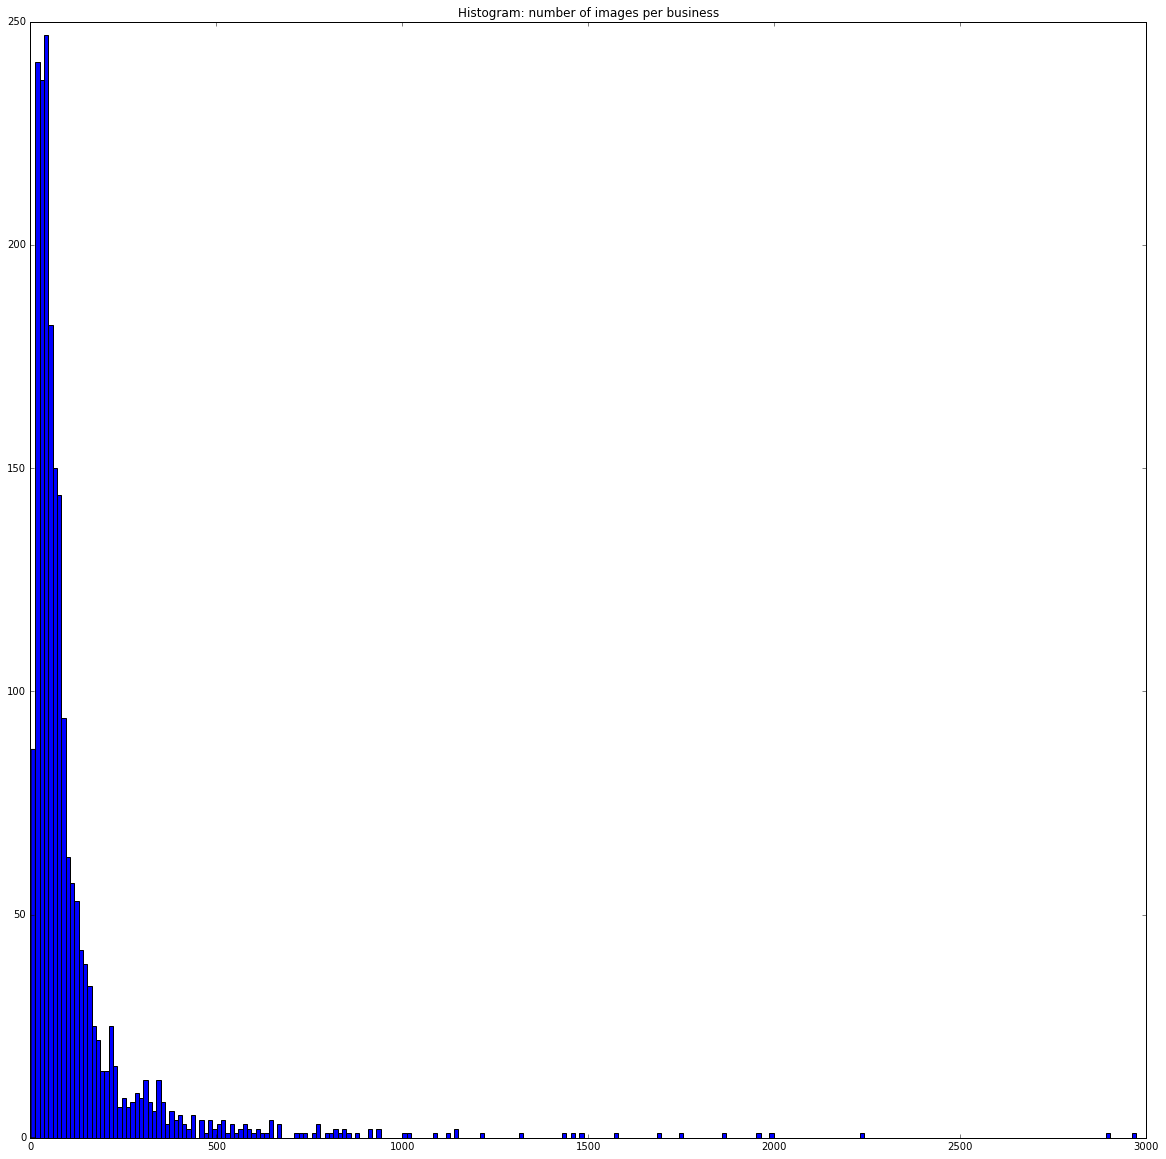

In [24]:
train_biz_ids = YelpData.train_biz_attrib_tbl.business_id.unique()
n_img_per_biz = np.array([ len(YelpData.get_train_image_ids_by_biz_id(biz_id)) for biz_id in train_biz_ids])
print('images per biz min = {}, max = {}, mean = {}, std = {}'.format(
        n_img_per_biz.min(), n_img_per_biz.max(), n_img_per_biz.mean(), n_img_per_biz.std()))
plt.hist(n_img_per_biz, log = False, bins = 256)
plt.title("Histogram: number of images per business")

In [25]:
def threshold_effect(t):
    
    num_biz = np.sum(n_img_per_biz < t)
    percent_biz = 100*np.sum(n_img_per_biz < t)/float(len(n_img_per_biz))
    
    num_imgs = np.sum(n_img_per_biz < t)
    percent_imgs = 100*np.sum(n_img_per_biz[n_img_per_biz < t])/float(np.sum(n_img_per_biz))
    # print('t = {}, compromises biz {}%, training images {}%'.format(t, percent_biz, percent_imgs))
    return percent_biz, percent_imgs

In [26]:
threshold_effect(15)

(5.3607214428857715, 0.48568736061540296)

*Need a model which takes variable number of images from a business as input and maps it to business attributes. This is tricky. One way to do so is to train the model with least amount of images available per business. But, the minimum is two which isn't sufficient for learning all the attributes. So we'd have to sacrifice some businesses. As it can be seen, there are 107 businesses which has < 15 images, contributing to total of 1139 images of the dataset, which seems like a pretty good threshold because it's only 0.48% of the total training images. Let's check the effect of threshold values in range 0-100*

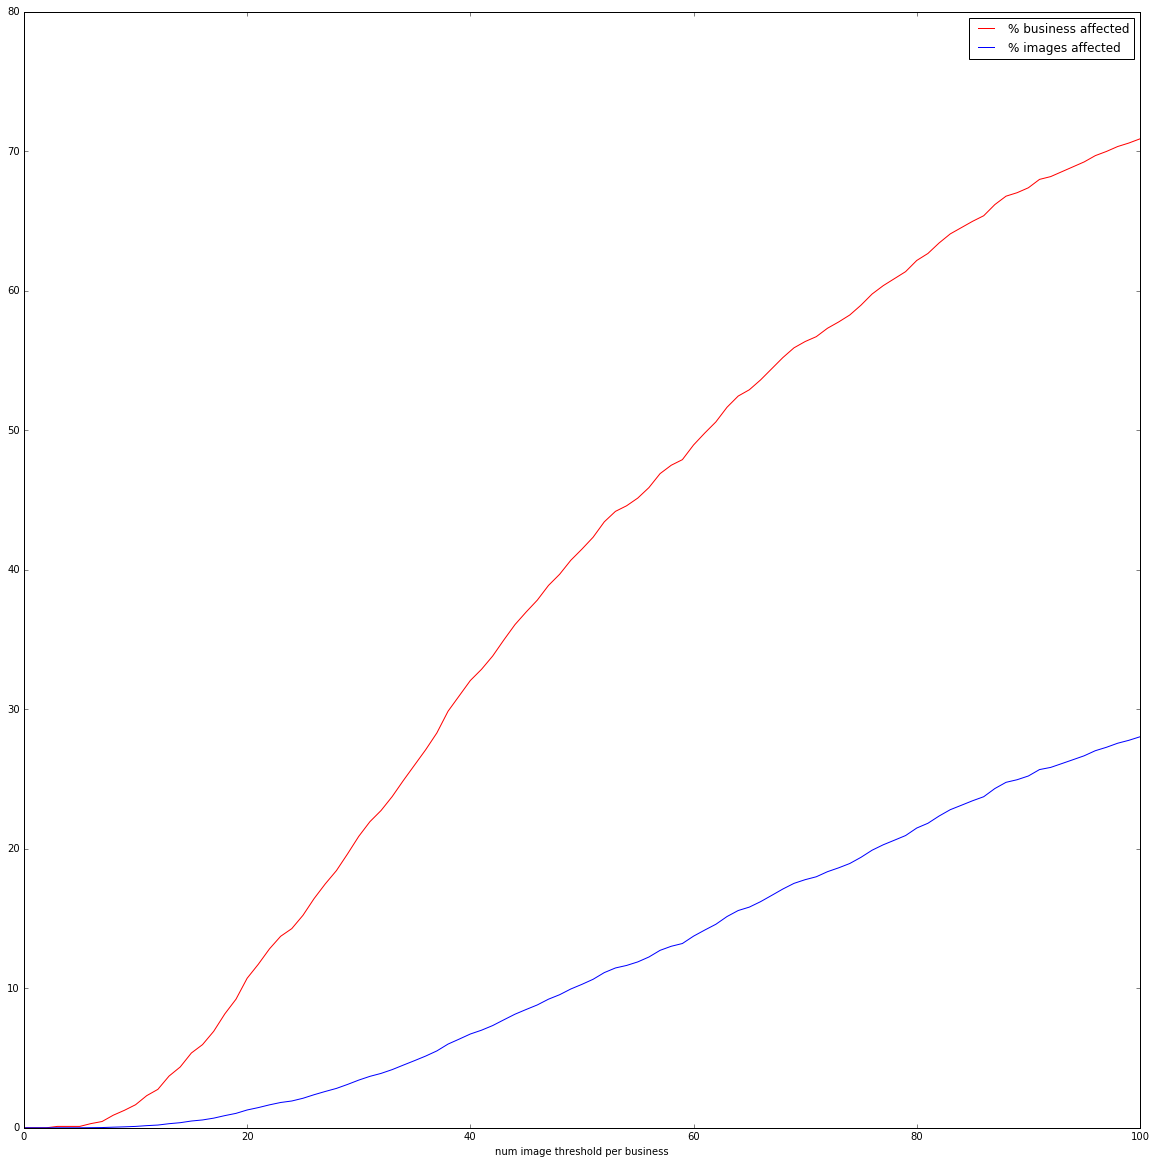

In [27]:
t_result_biz = []
t_result_imgs = []
t_range = range(101)
for t in t_range:
    b, i = threshold_effect(t)
    t_result_biz.append(b)
    t_result_imgs.append(i)
    
plt.xlabel("num image threshold per business")
plt.plot(t_range, t_result_biz, color="r", label="% business affected")
plt.plot(t_range, t_result_imgs, color="b", label="% images affected")
plt.legend()

Looking at the graph, presumably threshold 20 should be a good number of minimum images to filter businesses for training without impacting too much of a performance. 

In [28]:
print threshold_effect(20)

(10.721442885771543, 1.2775411171235709)
